In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.autonotebook import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')


from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.explainer import Explainer
from lightning_modules.surrogate import Surrogate
from vit_shapley.masks import apply_masks_to_batch
from vit_shapley.visualizations import get_heatmaps_grid
from vit_shapley.modules.explainer_utils import remake_masks, quick_test_masked

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

/tmp/ipykernel_2846958/4180679795.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
datamodule = DataModuleWithMasks(
    CIFAR10DataModule(),
    GenerateMasksKwargs(num_players=16),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 16])


# Loading models

In [3]:
surrogate = Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player16/vit_small_patch16_224",
    map_location="cuda",
)
surrogate.eval()
pass

In [4]:
explainer = Explainer.load_from_latest_checkpoint(
    "saved_models/explainer/cifar10/v4/player16/vit_small_patch16_224",
    map_location="cuda",
    surrogate=deepcopy(surrogate)
)
explainer.eval()
pass

In [5]:
surrogate.num_players, explainer.num_players, explainer.surrogate.num_players, datamodule.num_players

(16, 16, 16, 16)

In [6]:
explainer.hparams

"backbone":                  copy_surrogate
"divisor":                   4.0
"efficiency_class_lambda":   0.0
"efficiency_lambda":         0.0
"freeze_backbone":           none
"head_mlp_layer_ratio":      4
"head_num_attention_blocks": 0
"head_num_convolutions":     1
"num_classes":               10
"num_players":               16
"optimizer_kwargs":          {'opt': 'adamw', 'lr': 5e-05, 'lr_head': 0.0002, 'weight_decay': 0.0005}
"scheduler_kwargs":          {'sched': 'cosine', 'warmup_epochs': 1, 'min_lr': 1e-06}
"target_class_lambda":       0.0
"use_softmax":               False
"use_tanh":                  False

# Explainer visualization

In [7]:
with torch.no_grad():
    shap_values = explainer(images.to(explainer.device)).cpu()  # (batch=32, num_players=196, num_classes=10)
shap_values = shap_values[torch.arange(shap_values.shape[0]), :, labels] # (batch, num_players)
shap_values.shape

torch.Size([32, 16])

min=-0.439, max=2.177


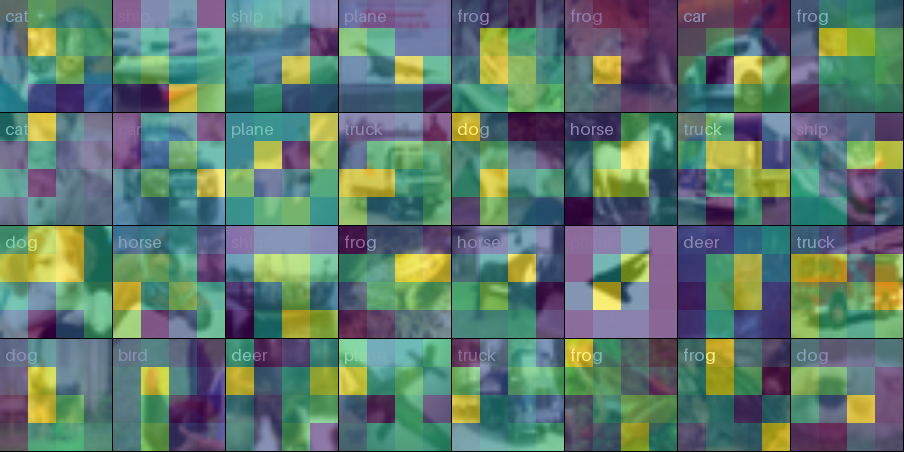

In [8]:
get_heatmaps_grid(images, labels, shap_values, alpha=0.6)

# Test best/worst/closest/furthest feature masking

In [9]:
quick_test_masked(surrogate, explainer, datamodule.test_dataloader())

100%|██████████| 313/313 [01:00<00:00,  5.15it/s, Masked-best-accuracy: 66.43%, Masked-worst-accuracy: 92.86%]


(66.43370607028754, 92.85642971246007)

In [10]:
from typing import Literal

def test_masked(
    surrogate: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    explainer: torch.nn.Module,
    players_to_mask: Literal["best", "worst", "random", "central", "peripheral"],
    device="cuda"
) -> None:
    results = []
    masked_percentages = []
    explainer.eval()
    surrogate.eval()
    with torch.no_grad():
        explainer.to(device)
        surrogate.to(device)
        correct, total = 0, 0
        with tqdm(dataloader, desc=players_to_mask) as dataloader_progress:
            for batch in dataloader_progress:
                images, masks, targets = batch['image'], batch['mask'], batch['label']
                images, masks, targets = images.to(device), masks.to(device), targets.to(device)
                shap_values = explainer(images) if (players_to_mask in ["best", "worst"]) else None
                masks = remake_masks(images, masks, targets, players_to_mask, explainer.num_players, shap_values)
                masks = masks.to(device)
                images, masks, targets = apply_masks_to_batch(images, masks, targets)

                logits = surrogate(images)
                _, predicted = logits.max(dim=1)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()
                results.extend(predicted.eq(targets).cpu().numpy())
                masked_percentages.extend((1 - masks.float()).mean(dim=1).cpu().numpy() * 100)
                dataloader_progress.set_postfix_str(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [11]:
import IPython.display
import ipywidgets

def plot(all_results: dict[str, pd.DataFrame], bucket_size: float = 100 / 14) -> None:
    # Smooth the plot by rounding 'masked %' to the nearest multiple of bucket_size.
    plot_results = deepcopy(all_results)
    for k, df in plot_results.items():
       df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, ax in enumerate(axs):
        for k, df in plot_results.items():
            ax.errorbar(
                x=list(df.groupby('masked %').groups.keys()),
                y=df.groupby('masked %').mean()["result"].to_list(),
                yerr=df.groupby('masked %').sem()["result"].mul(3).to_list(),
                label=k
            )
        ax.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
        ax.legend()
        ax.set_xlabel('masked %')
        ax.set_ylabel('accuracy')
        if i == 0:
            ax.set_xlim(0, 100)
            ax.set_ylim(0.4, 1)
        else:
            ax.set_xlim(0, 20)
            ax.set_ylim(0.9, 1)
    plt.show()

# Make a sub-output for updating the plot live.
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

with tqdm(range(2), desc="repeats") as repeats:
    for repeat in repeats:
        for players_to_mask in ["best", "worst", "central", "peripheral", "random"]:
            # Update plot
            plot_output.clear_output(wait=False)
            with plot_output:
                plot(all_results)
            # Test and update results
            df = test_masked(surrogate, datamodule.test_dataloader(), explainer, players_to_mask)
            if players_to_mask not in all_results:
                all_results[players_to_mask] = df
            else:
                all_results[players_to_mask] = pd.concat([all_results[players_to_mask], df])

# Update plot
plot_output.clear_output(wait=True)
with plot_output:
    plot(all_results)

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]